# Land use Classification: Using Arcmap and Python

This exercise will walks us through image classification using ArcMap and python. We will classifiy a clipped portion of landsat 8 image, first we will select training samples in ArcMap and then perform image classification using a Neural Network in Python.

Click [here](https://drive.google.com/drive/folders/1HQk2aMqL2LZbKCnOhDXYEzByiHbHDnXu?usp=sharing) to download the satellite image needed to follow this exercise.

__Output of each steps are provided to follow this exercise from any step. If you just want to skip to neural network portion click [here](#2).__


# Outline
- [ 1 - Data Preperation](#1)
  - [ 1.1 Dataset](#1.1)
  - [ 1.2 Preparing Training Samples](#1.2)
  - [ 1.3 Rasterizing the training samples](#1.3)
- [ 2 - Neural Network classification in python](#2)
  - [ 2.1 Improrting libraries and cleaning data](#2.1)
      - [ 2.1.1 Importing libraries](#2.1.1)
      - [ 2.1.2 Reshaping Arrays](#.1.2)
      - [ 2.1.3 Get Training Data](#2.1.3)
      - [ 2.1.4 Train - Test Split](#2.1.4)
  - [ 2.2 Building a model](#2.2)
  - [ 2.3 Training the model](#2.3)
  - [ 2.4 Saving and Loading the model](#2.4)
  - [ 2.5 Predicting using the model](#2.5)
      - [ 2.5.1 Model Evaluation](#2.5.1)
      - [ 2.5.2 Predict for the entire image](#2.5.2)
      - [ 2.5.3 Visualize the predicted classes](#2.5.3)
      - [ 2.5.4 Save the prediction as Raster](#2.5.4)


<a name = "1"></a>
## 1 - Data Preparation

<a name = "1.1"></a>
## 1.1 Dataset

We are using a portion of landsat 8 scene. [Landsat](https://www.usgs.gov/landsat-missions/landsat-8) images can be downloaded from [USGS EarthExplorer](https://earthexplorer.usgs.gov/) website. Then, using any desktop GIS or Remote Sensing software, the bands 1,2,3,4,5 and 7 can be merged into a single raster. Then the resulting raster can be clipped to the study area.

In this exercise, we are going to use the following image. Click [here](https://drive.google.com/file/d/1wOSROCVBPKxmTMmaEGhXA1YDiwddtkEd/view?usp=drive_link) to download.

<a name = "1.1"></a>
##  1.1 Preparing Training Samples

We will use the ArcMap Image Classification tool to create the training samples. If you don't have this tool  or software available, any other GIS software with this feature can be used.

__If you want to use the training samples provided, open the _Training Sample Manager_ and load the _trainingSample.shp_ file.__

First, open the __Image classification__ tool and start to __Draw Polygons__ as trainig class. If you have multiple images loaded, make sure in the dropdown of the __Image Classification__ tool, you have selected the correct image. Then draw several polygons for one class (For example: Water).



Second, open the __Training Sample Manager__ and merge the polygons to a single feature.


Now repeat step 1 and 2 for the next class. Make sure you change the __Value__ of each class so that it increases sequentially.
Do this for all the remaining classes.

Make sure you have enough training samples for each class. For better result, the number of training samples should be roughly proportional to the acutal area of each class in your data.


Just make sure that you have a well distributed training samples for each class.
If there are enough and well-distributed training samples, save them as for later use. Click the __Save training samples__ button in the __Training Sample Manger__ and save them in a appropriate location. These are the same as the _**trainingSample.shpe**_ file.



Now, on the right side of the __Training Sample Manger__, click the __Create signature file__ button. This will create  a signature file --a text file, that we will use for __Maximum likelihood classification__.


<a name = "1.2"></a>
## 1.2 Rasterizing the Training Samples

To used in the nural network, we will need to rasterize the training sample polygons. This can be done using __Polygon to Raster Tool__ in ArcMap.
Change the __Value Field__ to __Class Value__.

Make sure that you provide the actual clipped landsat image for the __cellsize__ parameter, __Processing extent__ envrionment variables __Extent__ and __Snap Raster__.

Make sure you end the name of output raster file with __.tif__.

Finally, make sure the number of rows and columns of your actual clipped landsat image and the output just created are the same. This can be checked from __Properites__ --> __Source__ --> __Raster Information__ -> Columns and Rows.

<a name="2"></a>
## 2 - Neural Network Classification in Python
[TensorFlow](https://www.tensorflow.org/) is a free and open-source software library for machine learning and artificial intelligence and can be used in [Python](https://www.python.org/downloads/). First, let's install some packages we will need. We will use [__numpy__](https://numpy.org/install/) for manipulating arrays or matrices, [__gdal__](https://pypi.org/project/GDAL/) for reading and writing rasters, [__matplotlib__](https://matplotlib.org/) for making graphs and plotting images and __tensorflow__ for building and training neural network. if any of these libraries are not found, install them by running the respective __pip install__ commands. Be sure the remove the '#'.

In [ ]:
! pip install numpy

In [ ]:
! pip install gdal

In [ ]:
! pip install matplotlib

In [75]:
! pip install tensorflow

In [ ]:
!pip install -q -U keras-tuner

<a name="2.1"></a>
## 2.1 Import Libraries and Cleaning Data

We will require gdal to read and write raster images. gdal will convert rasters to numpy arrays they they can be cleaned using numpy library. We will also need os module for chaning directories.
To use neural network we will use tensorflow library. Finally, to  perform hyperparameter tuning we will use keras-tuner.

<a name = "2.1.1"></a>
## 2.1.1 Importing Libraries

In [1]:
import os
import numpy as np
from osgeo import gdal

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

import keras_tuner as kt

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)


In [2]:
# Make sure to change the directory to appropriate folder
os.chdir('/content')

In [3]:
xds = gdal.Open('UpatyakaClip.tif')
yds = gdal.Open('TranShape3.tif')

In [5]:
X = xds.ReadAsArray()
y = yds.ReadAsArray()

In [6]:
print(f'Shape of input data is : {X.shape}.')

Shape of input data is : (6, 1930, 1723).


In [7]:
print(f'Shape of expected training classes is {y.shape}.')

Shape of expected training classes is (1930, 1723).


<a name="2.1.2"></a>
## 2.1.2 Reshaping Arrays
The shape of input data (x, y, z) means that there are 'x' bands, 'y' rows and 'z' columns in the input data. We want to reshape this data to a table-like format where each row represents one pixel and each column represents one band. This will be accomplished in two steps.
First, axis 0 which indicates number of bands, to the axis 2.
Second, reshape that array to array of shape _(n_row * n_cols, n_bands)_.

In [8]:
Xtab = np.moveaxis(X,0,2)
Xtab.shape

(1930, 1723, 6)

In [9]:
Xtab = Xtab.reshape(Xtab.shape[0]*Xtab.shape[1], Xtab.shape[2])
Xtab.shape

(3325390, 6)

Similary we will resahpe y in to an array of shape _(n_rows * n_cols, 1)_ .

In [10]:
y = y.reshape(y.shape[0]*y.shape[1],1)
y.shape

(3325390, 1)

<a name = '2.1.3'></a>
## 2.1.3 Get training data
Now our data is in the structure we want. But we will need to get the training data which is a subset of our whole data. The array y shows the corresponding classes of our training data. To get the training data only, we need to remove the NoData from both Xtab and y arrays. We will see what value represents NoData in yds.

In [11]:
nodata = yds.GetRasterBand(1).GetNoDataValue()
nodata

15.0

As we can see, the value 15 represents the NoData value in our trainig y data. We will remove the nodata values from our trainig data now.

In [12]:
dataIndex = (y != nodata)

In [13]:
len(dataIndex)


3325390

In [14]:
yclean = y[dataIndex]
Xclean = Xtab[dataIndex.flatten(),:]

In [15]:
Xclean.shape, yclean.shape

((20240, 6), (20240,))

In [16]:
np.unique(yclean)

array([0, 1, 2, 3], dtype=uint8)

In [17]:
np.unique(yclean)

array([0, 1, 2, 3], dtype=uint8)

<a name = "2.1.4"></a>
## 2.1.4 Train - Test Split
We will use the 80% of the cleaned data to train the model and the remaining 20% to validate the model. For this, we will use the [__argsort__](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) method and indexing for numpy arrays for randomly spliting data into training set and test set. We will also set the random seed to zero for consistency.

In [18]:
np.random.seed(0)
indices = np.random.sample(len(yclean))
indices


array([0.5488135 , 0.71518937, 0.60276338, ..., 0.95559388, 0.69631383,
       0.24282428])

In [19]:
indices.shape

(20240,)

In [20]:
sortedIndices = np.argsort(indices)

In [21]:
testlength = int(0.2*len(yclean))
testlength

4048

In [22]:
trainIndices = sortedIndices[testlength:]
testIndices = sortedIndices[:testlength]

In [25]:
Xtrain = Xclean[trainIndices]
ytrain = yclean[trainIndices]

Xtest = Xclean[testIndices]
ytest = yclean[testIndices]

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((16192, 6), (16192,), (4048, 6), (4048,))

Let's see how many unique classes are in our dataset.

In [24]:
np.unique(ytrain, return_counts = True)

(array([0, 1, 2, 3], dtype=uint8), array([3175, 5032, 4295, 3690]))

In [26]:
np.unique(ytest, return_counts = True)

(array([0, 1, 2, 3], dtype=uint8), array([ 817, 1247, 1047,  937]))

<a name = "2.2"></a>
## 2.2 Building a model
Now that our data is cleaned, we can build a neural network model using tensorflow. We will build a neural network with 2 hidden layers. We should provide the expected shape of input to the model. As we can see, each row in X will have 6 columns, so the expected input shape is (6,). Also, for output layer the number of nodes should be same as the number of classes that we want. As there are 4 classes in our ytrain data, that should be the number of nodes in output layer.

In [32]:

def create_uncompiled_model(hp):

    hp_units1 = hp.Int('units1', min_value=8, max_value=64, step=10)
    hp_units2 = hp.Int('units2', min_value=8, max_value=64, step=10)
    hp_units3 = hp.Int('units3', min_value=8, max_value=64, step=10)
    hp_units4 = hp.Int('units4', min_value=8, max_value=64, step=10)

    model = Sequential([
            tf.keras.Input(shape=(6,)),
            Dense(hp_units1, activation='relu', name = "L1"),
            Dense(hp_units2, activation='relu',  name = "L2"),
            Dense(hp_units3, activation='relu',  name = "L3"),
            Dense(hp_units4, activation='relu',  name = "L4"),
            Dense(4, activation='softmax', name = "L5"),  # Number of unique classes
        ], name = "my_model"
    )

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 2e-3, 4e-3, 7e-3, 1e-3, 1e-4, 1e-5, 1e-6])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics = ["accuracy"]
    )

    return model

In [ ]:
#del model
?kt.Hyperband

In [33]:
tuner = kt.Hyperband(create_uncompiled_model,
                     objective=kt.Objective('val_accuracy', direction = 'max'),
                     max_epochs=10,
                     factor=5,
                     directory='my_dir',
                     project_name='intro_to_kt'
                    )

In [34]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [37]:
tuner.search(Xtrain,ytrain, epochs=50, validation_data=(Xtest,ytest), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first dense layer is {best_hps.get('units1')}, for the second dense layer is {best_hps.get('units2')},for the third dense layer is {best_hps.get('units3')},and  for the fourth dense layer is {best_hps.get('units4')}.
""")


The hyperparameter search is complete. The optimal number of units in the first dense layer is 24, for the second dense layer is 64,for the third dense layer is 48,and  for the fourth dense layer is 64.



In [36]:
best_hps.get('learning_rate')

0.002

In [38]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(Xtrain, ytrain, epochs=50, validation_data = (Xtrain, ytrain))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
506/506 [==============================] - 5s 5ms/step - loss: 39.1570 - accuracy: 0.6479 - val_loss: 4.1868 - val_accuracy: 0.8048
Epoch 2/50
506/506 [==============================] - 2s 5ms/step - loss: 6.8826 - accuracy: 0.7062 - val_loss: 3.7959 - val_accuracy: 0.7525
Epoch 3/50
506/506 [==============================] - 3s 5ms/step - loss: 3.1412 - accuracy: 0.7361 - val_loss: 2.4179 - val_accuracy: 0.7920
Epoch 4/50
506/506 [==============================] - 2s 5ms/step - loss: 1.9935 - accuracy: 0.7443 - val_loss: 1.7000 - val_accuracy: 0.7350
Epoch 5/50
506/506 [==============================] - 3s 7ms/step - loss: 1.2385 - accuracy: 0.7603 - val_loss: 1.7439 - val_accuracy: 0.7933
Epoch 6/50
506/506 [==============================] - 2s 5ms/step - loss: 1.0747 - accuracy: 0.7539 - val_loss: 0.7788 - val_accuracy: 0.7792
Epoch 7/50
506/506 [==============================] - 2s 5ms/step - loss: 0.6530 - accuracy: 0.7817 - val_loss: 0.8361 - val_accuracy: 0.7955
Epoch

In [39]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Best epoch: 48


In [40]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(Xtrain, ytrain, epochs=best_epoch, validation_data = (Xtest, ytest))

Epoch 1/48
506/506 [==============================] - 5s 6ms/step - loss: 32.7844 - accuracy: 0.6999 - val_loss: 6.5293 - val_accuracy: 0.7478
Epoch 2/48
506/506 [==============================] - 2s 4ms/step - loss: 5.6254 - accuracy: 0.7379 - val_loss: 3.3005 - val_accuracy: 0.7794
Epoch 3/48
506/506 [==============================] - 2s 4ms/step - loss: 2.3247 - accuracy: 0.7467 - val_loss: 1.5354 - val_accuracy: 0.8246
Epoch 4/48
506/506 [==============================] - 2s 4ms/step - loss: 1.0667 - accuracy: 0.7780 - val_loss: 0.8178 - val_accuracy: 0.7945
Epoch 5/48
506/506 [==============================] - 2s 3ms/step - loss: 0.8423 - accuracy: 0.7695 - val_loss: 1.5739 - val_accuracy: 0.6873
Epoch 6/48
506/506 [==============================] - 2s 3ms/step - loss: 0.7405 - accuracy: 0.7714 - val_loss: 0.9017 - val_accuracy: 0.6727
Epoch 7/48
506/506 [==============================] - 2s 5ms/step - loss: 0.7324 - accuracy: 0.7779 - val_loss: 0.5767 - val_accuracy: 0.8209
Epoch

We are now ready to train.

<a name = "2.3"></a>
## 2.3 Training the model
Before training the model, we need to compile it. We will use _Sparse Categorical Cross entropy_ as a loss metric, which the model will try to minimize in successive iterations. We will use_ Adam_ optimzer for faster convergence.

The learning rate is a __hyperparameter__ which controls how fast the model parameters are updated in each iteration. For a bigger problem, different techniques are used to find a suitable value of this hyperparameter. Here we will use 0.001, wchich works for our case.

The __epoch__ refers to the number of times the model will see the entire training data. We will use the best epoch given by the hyperparameter tuning in this case.

Depending upon the computing resource, this may take some time.

In [45]:
from re import VERBOSE

hypermodel.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ["accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint_path = "./cp.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only= False, save_best_only= True, verbose=1, monitor = 'val_accuracy')

# Train the model with EarlyStopping callback
history = hypermodel.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=8, callbacks=[cp_callback, early_stop])


Epoch 1/8
499/506 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.8696
Epoch 1: val_accuracy improved from -inf to 0.87204, saving model to ./cp.h5
506/506 [==============================] - 6s 7ms/step - loss: 0.3417 - accuracy: 0.8692 - val_loss: 0.3405 - val_accuracy: 0.8720
Epoch 2/8
495/506 [============================>.] - ETA: 0s - loss: 0.3288 - accuracy: 0.8751
Epoch 2: val_accuracy improved from 0.87204 to 0.87500, saving model to ./cp.h5
506/506 [==============================] - 2s 4ms/step - loss: 0.3300 - accuracy: 0.8748 - val_loss: 0.3353 - val_accuracy: 0.8750
Epoch 3/8
502/506 [============================>.] - ETA: 0s - loss: 0.3361 - accuracy: 0.8752
Epoch 3: val_accuracy did not improve from 0.87500
506/506 [==============================] - 2s 5ms/step - loss: 0.3360 - accuracy: 0.8754 - val_loss: 0.3412 - val_accuracy: 0.8693
Epoch 4/8
489/506 [===========================>..] - ETA: 0s - loss: 0.3318 - accuracy: 0.8755
Epoch 4: val_accura

Let's visualize the how the loss is chaning over different epochs.

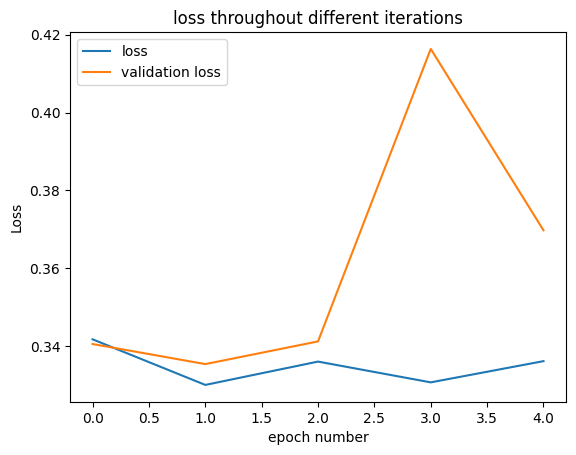

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label = "loss")
plt.plot(val_loss, label = "validation loss")
plt.title("loss throughout different iterations", fontsize = 12)
plt.xlabel('epoch number')
plt.ylabel('Loss')
plt.legend()
plt.show()


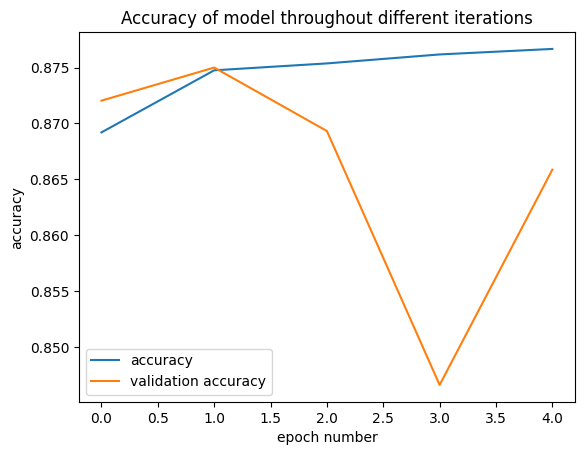

In [74]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(accuracy, label = "accuracy")
plt.plot(val_accuracy, label = "validation accuracy")
plt.title("Accuracy of model throughout different iterations", fontsize = 12)
plt.xlabel('epoch number')
plt.ylabel('accuracy')
plt.legend()
#plt.axvline(x=15)
plt.show()



<a name = "2.4"></a>
## 2.4 Saving and loading model
When you train a model, it is usually a good idea to save it so that you can later use it just for inference without training again. Following section shows how to save a model to current working directory and how to load a saved model.

In [48]:
np.max(accuracy)

0.8766674995422363

In [49]:
# Save model
hypermodel.save('myBestModel.h5')

# Load model
new_model = tf.keras.models.load_model('myBestModel.h5')

<a name = "2.5"></a>
## 2.5 Predicting using the model
Now we have trained our model, lets see how well it does with the training data. First, the model prediction will give an aray of 6 numbers for each input X, which we will pass through softmax method of nn class of tensorflow to get a relative probability of that row belonging to each of the 4 classes. Then we well use argmax method of numpy class to find the class with maximum probability for each row (axis = 1). The we will see what fraction of our prediction were same as the actual class.

In [50]:
predictionsTrain = hypermodel.predict(Xtrain)

506/506 [==============================] - 1s 1ms/step


In [51]:
predictionTrain_probs = tf.nn.softmax(predictionsTrain)

In [52]:
ypredTrain = np.argmax(predictionTrain_probs, axis = 1)

In [53]:
training_accuracy = np.mean(ypredTrain == ytrain)
training_accuracy

0.8698122529644269

<Axes: >

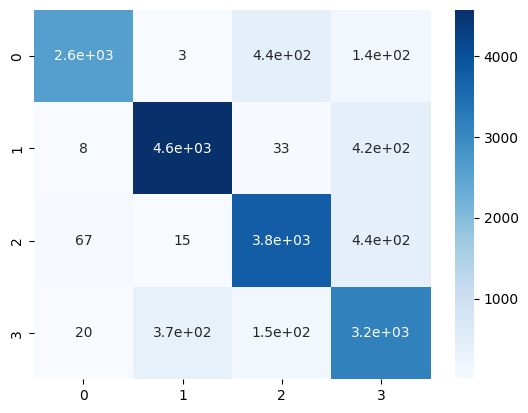

In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytrain, ypredTrain)
sns.heatmap(cm, annot = True, cmap = "Blues" )

It seems our model is doing pretty well on the training data. Lets see how well it does for unseed data.
We will then apply the model to the entire data we have, save it as a tif file using gdal which can be compared with the original image in any GIS software.

<a name = "2.5.1"></a>
## 2.5.1 Model Evaluation
Let's test our model performence in the test data.

127/127 [==============================] - 0s 2ms/step


<Axes: >

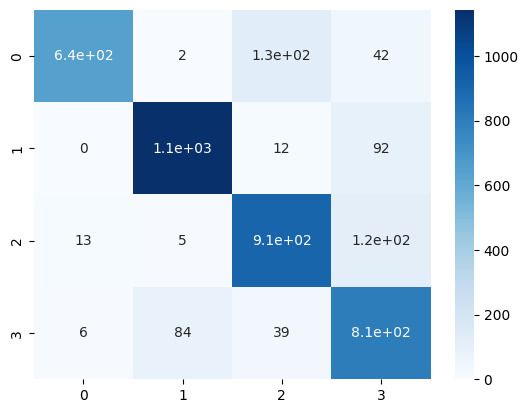

In [55]:
predictionsTest = hypermodel.predict(Xtest)
predictionTest_probs = tf.nn.softmax(predictionsTest)
ypredTest = np.argmax(predictionTest_probs, axis = 1)
test_accuracy = np.mean(ypredTest == ytest)

cm_test = confusion_matrix(ytest, ypredTest)
sns.heatmap(cm_test, annot = True, cmap = "Blues" )

In [56]:
print(f'The training accuracy is : {np.round(100*training_accuracy, 2)} %. ')
print(f'The test accuracy is : {np.round(100*test_accuracy,2)} %. ')

The training accuracy is : 86.98 %. 
The test accuracy is : 86.59 %. 


It seems that our model is doing well on both the training and test data with training accuray of 86.98 % and test accuracy of 86.59 %. If we assume that human can classify land use with accuracy of 99 % (just an example), then our model still has room for more than 13 % improvement. This shows that model is suffereing from __high-bias__, which can be minimized by using a __deeper neural network__, __training for more epochs__, or using __more variables__ such as band indices for classification.

If we assume that human level accuracy is 87 %, then our model is doing really well on the training data, but there is room for improvement on test data. This would constitute a __high-variance__ problem, which can be addressed by adding __more training examples__ or by __increasing regularization__.

We will leave this bias-variance analysis for the future. Now we well see what the classification result looks like on the entire image.

<a name = "2.5.2"></a>
## 2.5.2 Predict for the entire data

We already have our entire data reshaped and saved in the variable Xtab. We can direclty apply the model to this data. Then we will need to reshape the output to the shape of original input data before we save it as a raster.

In [57]:
allPredictions = hypermodel.predict(Xtab)

103919/103919 [==============================] - 171s 2ms/step


In [58]:
allPredictions_probs = tf.nn.softmax(allPredictions)

In [59]:
Ypred = np.argmax(allPredictions_probs, axis = 1)

In [60]:

Ypred.shape

(3325390,)

In [61]:
Ypred = Ypred.reshape(yds.ReadAsArray().shape)

<a name = "2.5.3"></a>
## 2.5.3 Visualize the predicted classes

In [62]:
cmap=ListedColormap(['#00c', 'green', '#ff3f14', '#8bcd8d']) #,'#8bcd8d', 'yellow', '#ff3f14'])

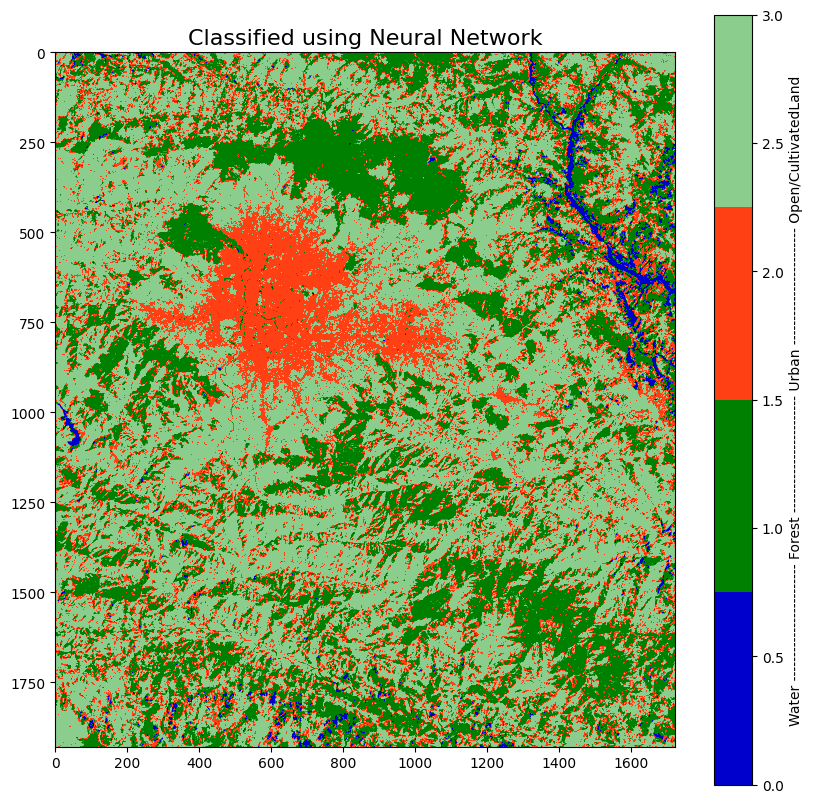

In [71]:
plt.figure(figsize = (10,10))
plt.imshow(Ypred, cmap = cmap)
plt.colorbar(label = ' ------------------------ '.join(['Water', 'Forest','Urban','Open/CultivatedLand'])) #,'Water', 'Sand', 'Forest', 'Grass', 'Cultivation', 'Built up' ]))
plt.title('Classified using Neural Network', fontsize = 16)
plt.show()

<a name = "2.5.4"></a>
## 2.5.4 Save the prediction as Raster
We can use gdal to write the prediction as a raster. First we will create a _geotiff_ dataset, take its first band and write the prediction to it. Then set the coordinate reference system and geotransform which will  be the same as that of inpput _xds_. Finally, we need to call FlushCache method so that changes will be written on disk and that can be properly opened in other software.

In [69]:
driver_gtiff = gdal.GetDriverByName('GTiff')

ds_create = driver_gtiff.Create('predicted.tif', xsize=Ypred.shape[1], ysize=Ypred.shape[0], bands=1)
ds_create.GetRasterBand(1).WriteArray(Ypred)

ds_create.SetProjection(xds.GetProjection())
ds_create.SetGeoTransform(xds.GetGeoTransform())
ds_create.GetRasterBand(1).FlushCache()
ds_create.FlushCache()

__Congratulations!__ Now you know how to use neural networks to classify satellite images. Good luck on your learning journey.